In [1]:
# Common DS imports
import pandas as pd
import numpy as np

#Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Exploration and modeling Libraries
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics


#Helpers
import wrangle #'./wrangle.py'

# DS Pipeline step 1: Acquire
This section will serve as documentation for the process of getting the data into a python environment.  At the end of this section each step will be compiled and documented into a set of functions whose purpose will be to make repeating the process as simple as possible.

### Requirements
The process will make use of libraries not included with the base installation of python.  

In [2]:
# """
# These commands will install the listed libraries in your python environment.
# Since they are only helpful if libraries are missing, to avoid accidentally running them they have been commented out.
# If you want to run these commands they will first need to be uncommented (Delete the '#' character at the start of each line)
# """

# %pip install numpy
# %pip install pandas
# %pip install matplotlib
# %pip install seaborn
# %pip install scipy
# %pip install sklearn

### Setting up the SQL code
The data for this project lives on CodeUp's MySQL server, so I will need to use python to connect to the server and download the data.  Luckily, pandas includes a method specefically meant for this scenario: `pd.read_sql()`

The hardest part of using this method is formatting the URL used in the method without exposing my credentials.  To get around that, I'll store my credentials in a secret `env.py` file and write a function that can be used to create the URL dynamically.  I happen to have one ready-made so there's no need for me to re-invent the wheel.

In [3]:
def get_db_url(database, hostname='', username='', password='', env=''):
    '''Creates a URL for a specific database and credential set to be used with pymysql.

    Can be used either with a set of credentials passed directly to the function or with an environment file containing the credentials.
    If both are provided, the environment file takes precedence.

    Parameters:
    database (str): The target database that pymysql will connect to, which will provide context for any SQL queries used in the connection.
    hostname (str): The DNS hostname or IP-Adress for the connection
    username (str), password (str): User credentials that will be used in a sql connection.
    env (str): Relative path to an environment file. ('./env.py')  The file must include the hostname, username, and password variables.

    Returns:
    str: Full URL for use with a pymysql connection
    '''
    if env != '':
        d = {}
        file = open(env)
        for line in file:
            (key, value) = line.split('=')
            d[key] = value.replace('\n', '').replace("'",'').replace('"','')
        username = d['username']
        hostname = d['hostname']
        password = d['password']
    url = f'mysql+pymysql://{username}:{password}@{hostname}/{database}'
    return url


Now that the function has been declared we can feed it into the `pandas.read_sql()` method and start pulling some data.

In [4]:
# Use our get_db_url() function to create a properly formatted url and store it into its own variable to make things easier to read later.
url = get_db_url('telco_churn', env='./env.py')

# SQL syntax can get unruly, and this particular query isn't exactly straightforward. So we'll store it in its own variable as well.
query = """
        SELECT 
            *
        FROM
            telco_churn.customers
                JOIN
            telco_churn.internet_service_types USING (internet_service_type_id)
                JOIN
            telco_churn.payment_types USING (payment_type_id)
                JOIN
            telco_churn.contract_types USING (contract_type_id)
        ;
        """

# Now it's time to use pandas to import our data.  
df = pd.read_sql(query, url)

# Display the first two rows to make sure the import was successful
df.head(2)

,contract_type_id,payment_type_id,internet_service_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,internet_service_type,payment_type,contract_type
0,2,2,1,0002-ORFBO,Female,0,Yes,Yes,9,Yes,...,Yes,Yes,No,Yes,65.6,593.3,No,DSL,Mailed check,One year
1,1,2,1,0003-MKNFE,Male,0,No,No,9,Yes,...,No,No,Yes,No,59.9,542.4,No,DSL,Mailed check,Month-to-month


Next we'll package this process up into its own function and commit it to `wrangle.py`

In [5]:
def new_telco_data():
    url = get_db_url('telco_churn',env='./env.py')
    query = """
        SELECT 
            *
        FROM
            telco_churn.customers
                JOIN
            telco_churn.internet_service_types USING (internet_service_type_id)
                JOIN
            telco_churn.payment_types USING (payment_type_id)
                JOIN
            telco_churn.contract_types USING (contract_type_id)
        ;
        """
    df = pd.read_sql(query, url)
    return df

# Let's make sure it works
new_telco_data().head(2)

,contract_type_id,payment_type_id,internet_service_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,internet_service_type,payment_type,contract_type
0,2,2,1,0002-ORFBO,Female,0,Yes,Yes,9,Yes,...,Yes,Yes,No,Yes,65.6,593.3,No,DSL,Mailed check,One year
1,1,2,1,0003-MKNFE,Male,0,No,No,9,Yes,...,No,No,Yes,No,59.9,542.4,No,DSL,Mailed check,Month-to-month


In [6]:
# And also make sure it works when imported from our helper library
wrangle.new_telco_data().head(2)

,contract_type_id,payment_type_id,internet_service_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,internet_service_type,payment_type,contract_type
0,2,2,1,0002-ORFBO,Female,0,Yes,Yes,9,Yes,...,Yes,Yes,No,Yes,65.6,593.3,No,DSL,Mailed check,One year
1,1,2,1,0003-MKNFE,Male,0,No,No,9,Yes,...,No,No,Yes,No,59.9,542.4,No,DSL,Mailed check,Month-to-month


### Cacheing the data
Now that we have the data in hand I should store it locally.  This will speed things up by not having to download a new copy of the data each time.  It also ensures that we can still access the data in the event of a server outage.

Pandas helps us again with its `pandas.to_csv()` method.

In [7]:
# Store the data in a csv file in this directory with the name telco.csv


# df.to_csv('./telco.csv') #Commented out to reduce write-cycles on my system's drive

Of course, this only helps us if we can read the data from the CSV file as well.  We'll do so with `pandas.read_csv()`

In [8]:
# Read the data from our newly created csv file.
pd.read_csv('./telco.csv').head(2)

,Unnamed: 0,contract_type_id,payment_type_id,internet_service_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,internet_service_type,payment_type,contract_type
0,0,2,2,1,0002-ORFBO,Female,0,Yes,Yes,9,...,Yes,Yes,No,Yes,65.6,593.3,No,DSL,Mailed check,One year
1,1,1,2,1,0003-MKNFE,Male,0,No,No,9,...,No,No,Yes,No,59.9,542.4,No,DSL,Mailed check,Month-to-month


Hmm.. It looks like there's a new column there that we don't want: `Unnamed: 0`.  This happens because when we asked pandas to write our data to a file, it also included the dataframe index.
Luckily we can tell pandas that our file includes an index by passing in the argument `index_col=`. 

In [9]:
# Read the data again, this time declaring which column to use as the dataframe index.
pd.read_csv('./telco.csv', index_col=0).head(2)

,contract_type_id,payment_type_id,internet_service_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,internet_service_type,payment_type,contract_type
0,2,2,1,0002-ORFBO,Female,0,Yes,Yes,9,Yes,...,Yes,Yes,No,Yes,65.6,593.3,No,DSL,Mailed check,One year
1,1,2,1,0003-MKNFE,Male,0,No,No,9,Yes,...,No,No,Yes,No,59.9,542.4,No,DSL,Mailed check,Month-to-month


Great!  But we also don't want to have to keep track of whether or not there's already a csv file cached and which method to use to acquire the data.  We'll create a function for that:

In [10]:
# This function makes use of the `os` library.  We'll have to import it first.
import os

def get_telco_data():
    filename = "telco.csv"
    
    # if file is available locally, read it
    if os.path.isfile(filename):
        return pd.read_csv(filename, index_col=0)
    
    # if file not available locally, acquire data from SQL database
    # and write it as csv locally for future use
    else:
        # read the SQL query into a dataframe
        df = new_telco_data()
        
        # Write that dataframe to disk for later. Called "caching" the data for later.
        df.to_csv(filename)

        # Return the dataframe to the calling code
        return df  

# Make sure it works
get_telco_data().head(2)

,contract_type_id,payment_type_id,internet_service_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,internet_service_type,payment_type,contract_type
0,2,2,1,0002-ORFBO,Female,0,Yes,Yes,9,Yes,...,Yes,Yes,No,Yes,65.6,593.3,No,DSL,Mailed check,One year
1,1,2,1,0003-MKNFE,Male,0,No,No,9,Yes,...,No,No,Yes,No,59.9,542.4,No,DSL,Mailed check,Month-to-month


In [11]:
# And also make sure it works from our helper library
df = wrangle.get_telco_data()
df.head(2)

,contract_type_id,payment_type_id,internet_service_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,internet_service_type,payment_type,contract_type
0,2,2,1,0002-ORFBO,Female,0,Yes,Yes,9,Yes,...,Yes,Yes,No,Yes,65.6,593.3,No,DSL,Mailed check,One year
1,1,2,1,0003-MKNFE,Male,0,No,No,9,Yes,...,No,No,Yes,No,59.9,542.4,No,DSL,Mailed check,Month-to-month


# DS Pipeline Step 2: Preparation

There's a lot of columns here, and the dataframe is too wide for our notebook to display it properly. We will want to think about trimming this down, so we'll use python to generate a list programatically and also get some basic information about each column.

The first method we'll use is `.info()` which gives us a lot of useful information in one go
 - The number of entries (rows)
 - The number of features (columns)
 - The number of non-null values in each column
 - The data type (Dtype) of each column

In [12]:
# Use DataFrame.info() to get a list of columns.
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   contract_type_id          7043 non-null   int64  
 1   payment_type_id           7043 non-null   int64  
 2   internet_service_type_id  7043 non-null   int64  
 3   customer_id               7043 non-null   object 
 4   gender                    7043 non-null   object 
 5   senior_citizen            7043 non-null   int64  
 6   partner                   7043 non-null   object 
 7   dependents                7043 non-null   object 
 8   tenure                    7043 non-null   int64  
 9   phone_service             7043 non-null   object 
 10  multiple_lines            7043 non-null   object 
 11  online_security           7043 non-null   object 
 12  online_backup             7043 non-null   object 
 13  device_protection         7043 non-null   object 
 14  tech_sup

The first thing that stands out to me is there seem to be some columns (`'contract_type_id', 'payment_type_id', 'internet_service_type_id'`) that are essentially duplicated.  In fact, we know that they are because they were the columns we used to join when we wrote the SQL query.  We can safely drop those columns.

In [13]:
# Drop columns that just repeat the data in other columns
df = df.drop(columns=['contract_type_id', 'payment_type_id', 'internet_service_type_id'])
print( df.columns.to_list() )

['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents', 'tenure', 'phone_service', 'multiple_lines', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'paperless_billing', 'monthly_charges', 'total_charges', 'churn', 'internet_service_type', 'payment_type', 'contract_type']


Also from running `.info()` we can see that we are working with 7043 entries. It looks like none of them have null values, but we can't always trust that for its face value.  Stepping through each column and seeing what data lives in them will give us more insight into whethere there are any 'functionally null' values, like blank strings or strings meant to represent a null value in the data.  

In this case, because we don't have a data dictionary provided for us and will need to infer it ourselves, going through each column will also give us some insight into what each column is meant to represent.

In [14]:
# To make the cell output more manageable later I will focus on the columns that are likely to have a lot of different values first.
df.customer_id.value_counts()

0002-ORFBO    1
6616-AALSR    1
6625-UTXEW    1
6625-IUTTT    1
6625-FLENO    1
             ..
3352-RICWQ    1
3352-ALMCK    1
3351-NQLDI    1
3351-NGXYI    1
9995-HOTOH    1
Name: customer_id, Length: 7043, dtype: int64

There doesn't appear to be any null values here, and we can see that each row seems to be unique so we can go ahead and use the column's name to infer the first column of our data dictionary.
> **customer_id**: A unique identifier that represents a single customer

In [15]:
df.tenure.value_counts()

1     613
72    362
2     238
3     200
4     176
     ... 
28     57
39     56
44     51
36     50
0      11
Name: tenure, Length: 73, dtype: int64

This one requires a bit more thought to decipher.  Looking up the dictionary definition for "tenure" we can find a defintion of "a period for which an office is held".  Because none of the other definitions make sense for a telecom company and wouldn't be stored as an integer it can be assumed that tenure is meant to be a measure of how long a customer has been with the company.

Since I don't imagine a single customer having a tenure of 613 years, and it would be resource intensive to update a database each day with the new values, we can infer this columns as:
> **tenure**: The number of months a customer has been a customer.

In [16]:
df.monthly_charges.value_counts()

20.05     61
19.85     45
19.95     44
19.90     44
20.00     43
          ..
116.55     1
106.85     1
68.55      1
108.80     1
67.85      1
Name: monthly_charges, Length: 1585, dtype: int64

This is a float variable with lots of different values.  It's safe to assume it is what it says on the tin:
> **monthly_charges**: The amount a customer is charged each month

In [71]:
df.total_charges.value_counts().nlargest(3)

0.00     11
20.20    11
19.75     9
Name: total_charges, dtype: int64

**Hold up!**  
It's easy to miss it, but did you see what happened here?  
There are 11 values that appear to be blank.  This is because SQL returned those null values as empty strings, which is technically not a null value.

Because these 11 rows are such a small part of our dataset it's easy to say that we can just drop them.  But I'd like to take a closer look at them to see if there is any information to be gleaned from this abnormality, especially since the rest of the dataset seems so well maintained.

In [18]:
# Get a list of all customers where total charges is a single space
mask = (df.total_charges == ' ')
df[mask]

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,internet_service_type,payment_type,contract_type
945,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,Yes,Yes,...,Yes,Yes,No,No,56.05,,No,DSL,Credit card (automatic),Two year
1731,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No internet service,No internet service,...,No internet service,No internet service,No internet service,No,20.00,,No,None,Mailed check,Two year
1906,2775-SEFEE,Male,0,No,Yes,0,Yes,Yes,Yes,Yes,...,Yes,No,No,Yes,61.90,,No,DSL,Bank transfer (automatic),Two year
2025,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No internet service,No internet service,...,No internet service,No internet service,No internet service,Yes,19.70,,No,None,Mailed check,One year
2176,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No internet service,No internet service,...,No internet service,No internet service,No internet service,No,20.25,,No,None,Mailed check,Two year
2250,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No internet service,No internet service,...,No internet service,No internet service,No internet service,No,25.35,,No,None,Mailed check,Two year
2855,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,No,Yes,...,Yes,Yes,No,No,73.35,,No,DSL,Mailed check,Two year
3052,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No internet service,No internet service,...,No internet service,No internet service,No internet service,No,25.75,,No,None,Mailed check,Two year
3118,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,Yes,No,...,Yes,Yes,No,Yes,52.55,,No,DSL,Bank transfer (automatic),Two year
4054,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,Yes,Yes,...,No,Yes,Yes,No,80.85,,No,DSL,Mailed check,Two year


Each of these customers have a tenure of 0.  It makes sense that their total charges would be 0 if they haven't been around long enough to be charged.  
Do these customers make up the entirety of the new customers?

In [19]:
# Get the number of customers with 0 tenure.
(df.tenure == 0).sum()

11

Yes they do.  To fix this we can replace the missing values with 0.

In [20]:
# Replaces the spaces in total_charges with a 0 and sets the column's type to a float
df.total_charges = df.total_charges.replace(' ', 0).astype(np.float64)

And finally we can infer the description for this column:
> **total_charges**: The total amount that has been charged to a customer over their tenure

There are still a lot of columns remaining, and doing them all one at a time would take a long time.  To save time we'll loop through all of the remaining columns and look at their value counts.

In [21]:
columns_to_skip = ['customer_id','tenure','monthly_charges','total_charges']

#Loop through each column in the dataframe, and if we haven't done them already, print their value counts.
for col in df:
    if col not in columns_to_skip:
        print(df[col].value_counts(), '\n')

Male      3555
Female    3488
Name: gender, dtype: int64 

0    5901
1    1142
Name: senior_citizen, dtype: int64 

No     3641
Yes    3402
Name: partner, dtype: int64 

No     4933
Yes    2110
Name: dependents, dtype: int64 

Yes    6361
No      682
Name: phone_service, dtype: int64 

No                  3390
Yes                 2971
No phone service     682
Name: multiple_lines, dtype: int64 

No                     3498
Yes                    2019
No internet service    1526
Name: online_security, dtype: int64 

No                     3088
Yes                    2429
No internet service    1526
Name: online_backup, dtype: int64 

No                     3095
Yes                    2422
No internet service    1526
Name: device_protection, dtype: int64 

No                     3473
Yes                    2044
No internet service    1526
Name: tech_support, dtype: int64 

No                     2810
Yes                    2707
No internet service    1526
Name: streaming_tv, dtype: int64

Most of the remaining columns can be retyped into booleans, which tend to work better with machine learning models.  There are some columns that in addition to the Yes/No values there is a value determining whether the customer has the appropriate internet service or phone service for the column to be applicable.  However, we can already infer that information from the `phone_service` and `internet_service_type` columns.  Therefore we can convert all of the remaining columns, with the exception of `internet_service_type`, `payment_type`, and `contract_type` into boolean columns.

In [22]:
# Convert the senior citizen column into boolean type.
# We want to handle this one separetely because unlike the others, it uses 1's and 0's instead of Yes/No
df.senior_citizen = df.senior_citizen == 1
# Do something similar with gender
df.gender = df.gender == 'Male'
# Also rename the gender column to make it more intuitive to read later.
df.rename(columns={'gender': 'is_male'}, inplace=True)


In [23]:
# Loop through the yes/no columns and convert them to booleans.
yes_no_columns = [ 'partner',
                    'dependents',
                    'phone_service',
                    'multiple_lines',
                    'online_security',
                    'online_backup',
                    'device_protection',
                    'tech_support',
                    'streaming_tv',
                    'streaming_movies',
                    'paperless_billing',
                    'churn'
                    ]
for column in yes_no_columns:
    df[column] = df[column] == "Yes"

In [24]:
# Make sure all of the transformations look how we expect
df.head(5)

,customer_id,is_male,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,internet_service_type,payment_type,contract_type
0,0002-ORFBO,False,False,True,True,9,True,False,False,True,...,True,True,False,True,65.6,593.30,False,DSL,Mailed check,One year
1,0003-MKNFE,True,False,False,False,9,True,True,False,False,...,False,False,True,False,59.9,542.40,False,DSL,Mailed check,Month-to-month
2,0004-TLHLJ,True,False,False,False,4,True,False,False,False,...,False,False,False,True,73.9,280.85,True,Fiber optic,Electronic check,Month-to-month
3,0011-IGKFF,True,True,True,False,13,True,False,False,True,...,False,True,True,True,98.0,1237.85,True,Fiber optic,Electronic check,Month-to-month
4,0013-EXCHZ,False,True,True,False,3,True,False,False,False,...,True,True,False,True,83.9,267.40,True,Fiber optic,Mailed check,Month-to-month


So far we've made a fair amount of transformations to the data and now we have a dataframe that's ready for exploration.  Let's take a moment to compile into a function and add it to the `wrangle.py` file.

In [25]:
def get_tidy_telco_data():
    # Get a fresh copy of the data
    df = get_telco_data()
    # Drop columns that just repeat the data in other columns
    df = df.drop(columns=['contract_type_id', 'payment_type_id', 'internet_service_type_id'])
    # Replace the spaces in total_charges with a 0 and sets the column's type to a float
    df.total_charges = df.total_charges.replace(' ', 0).astype(np.float64)
    # Convert the senior citizen column into boolean type.
    # We want to handle this one separetely because unlike the others, it uses 1's and 0's instead of Yes/No
    df.senior_citizen = df.senior_citizen == 1
    # Do something similar with gender
    df.gender = df.gender == 'Male'
    # Also rename the gender column to make it more intuitive to read later.
    df.rename(columns={'gender': 'is_male'}, inplace=True)
    # Loop through the yes/no columns and convert them to booleans.
    yes_no_columns = [ 'partner',
                    'dependents',
                    'phone_service',
                    'multiple_lines',
                    'online_security',
                    'online_backup',
                    'device_protection',
                    'tech_support',
                    'streaming_tv',
                    'streaming_movies',
                    'paperless_billing',
                    'churn']
    for column in yes_no_columns:
        df[column] = df[column] == "Yes"
    return df

# Test functionality
get_tidy_telco_data().head(2)    

,customer_id,is_male,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,internet_service_type,payment_type,contract_type
0,0002-ORFBO,False,False,True,True,9,True,False,False,True,...,True,True,False,True,65.6,593.3,False,DSL,Mailed check,One year
1,0003-MKNFE,True,False,False,False,9,True,True,False,False,...,False,False,True,False,59.9,542.4,False,DSL,Mailed check,Month-to-month


Because we know we are going to be making machine learning models from the data, it is a good idea to create dummy columns (a set of boolean columns where each column corresponds to each of the possible categories in a different column) for the categorical variables.  Pandas includes a method called `get_dummies` that simplifies the process.



However, carrying those columns around during exploration can be unweildy so we'll pack that process into a separate function that we can call later when it's time to mess with modeling.

In [26]:
# Demonstration of the get_dummies() method
pd.get_dummies(df, columns=['internet_service_type', 'payment_type', 'contract_type'], dtype=bool).head(2)

,customer_id,is_male,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,...,internet_service_type_DSL,internet_service_type_Fiber optic,internet_service_type_None,payment_type_Bank transfer (automatic),payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check,contract_type_Month-to-month,contract_type_One year,contract_type_Two year
0,0002-ORFBO,False,False,True,True,9,True,False,False,True,...,True,False,False,False,False,False,True,False,True,False
1,0003-MKNFE,True,False,False,False,9,True,True,False,False,...,True,False,False,False,False,False,True,True,False,False


In [27]:
def get_tidier_telco_data():
    df = get_tidy_telco_data()
    df = pd.get_dummies(df, columns=['internet_service_type', 'payment_type', 'contract_type'], dtype=bool)
    df.columns = df.columns.str.lower()
    return df

# Test the new function
get_tidier_telco_data().head(2)

,customer_id,is_male,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,...,internet_service_type_dsl,internet_service_type_fiber optic,internet_service_type_none,payment_type_bank transfer (automatic),payment_type_credit card (automatic),payment_type_electronic check,payment_type_mailed check,contract_type_month-to-month,contract_type_one year,contract_type_two year
0,0002-ORFBO,False,False,True,True,9,True,False,False,True,...,True,False,False,False,False,False,True,False,True,False
1,0003-MKNFE,True,False,False,False,9,True,True,False,False,...,True,False,False,False,False,False,True,True,False,False


Later, while writing Final_Report.ipynb I discovered that the dummy columns method actually drops the originating columns from which the dummy columns are derived.  So the above function has been updated:

In [28]:
def get_tidier_telco_data():
    df = get_tidy_telco_data()
    dummy_columns = ['internet_service_type', 'payment_type', 'contract_type']
    temp_df = df[dummy_columns]
    df = pd.get_dummies(df, columns=dummy_columns, dtype=bool)
    df = pd.concat([df, temp_df], axis=1)
    df.columns = df.columns.str.lower()
    return df

Also, because we are creating a machine learning model it is important to avoid over-fitting.  We can take steps in that direction by splitting the data before we begin exploration.  
To do so we'll use sklearn's `test_train_split` functionality to split the data into separate dataframes.  Traditionally these would be split into three parts (train, test, and validate), but because I imagine that I will want to try a lot of different models I will instead split into four parts (train, test, validate, and verify).

The final percentages of the dataset should be:
 - train: 50%
 - test: 20%
 - validate: 15%
 - verify: 15%

The verify dataset will be used only once to verify that the model I choose as the best performs as expected on data that it's never seen before.

In [29]:
from sklearn.model_selection import train_test_split

def train_test_validate_verify_split(df, seed=8, stratify='churn'):
    # First split off our training data.
    train, tvv = train_test_split(
        df, 
        test_size=1/2, 
        random_state=seed, 
        stratify=( df[stratify] if stratify else None)
    )
    # Then split our testing data.
    test, vv = train_test_split(
        tvv,
        test_size=3/5,
        random_state=seed,
        stratify= (tvv[stratify] if stratify else None)
    )
    # Then split validate and verify data.
    validate, verify = train_test_split(
        vv,
        test_size=1/2,
        random_state=seed,
        stratify= (vv[stratify] if stratify else None)
    )
    return train, test, validate, verify

In [30]:
# split the data
train, test, validate, verify = train_test_validate_verify_split(df)

# verify the lengths are what I expect
t = len(df)
a = len(train)
b = len(test)
c = len(validate)
d = len(verify)

a/t, b/t, c/t, d/t


(0.4999290075252023,
 0.1999148090302428,
 0.15007809172227743,
 0.15007809172227743)

#### Data Dictionary

Now that we have gone through the trouble of preparing each column for machine learning, we have enough information to build our data dictionary.

In [ ]:
df.columns.tolist()

['contract_type_id',
 'payment_type_id',
 'internet_service_type_id',
 'customer_id',
 'gender',
 'senior_citizen',
 'partner',
 'dependents',
 'tenure',
 'phone_service',
 'multiple_lines',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'paperless_billing',
 'monthly_charges',
 'total_charges',
 'churn',
 'internet_service_type',
 'payment_type',
 'contract_type']

|Column | Description|
|---|---|
| `customer_id` | Unique identifier for the customer |
| `churn` | Yes/No - Yes if customer left company |
| `gender` | Gender of the customer |
| `senior_citizen` | 0/1 - 1 if the customer is a senior citizen |
| `partner` | Yes/No - Yes if customer has a spouse or partner |
| `dependents` | Yes/No - Yes if customer has children or dependents |
| `tenure` | Measure in months of how long customer has been with company |
| `phone_service` | Yes/No - Yes if customer has phone service |
| `multiple_lines` | Does customer with phone service have more than one line? |
| `online_security` | Does customer use online security services? |
| `online_backup` | Does customer use online backup services? |
| `device_protection` | Does customer use device protection services? |
| `tech_support` | Does customer use technical support services? |
| `streaming_tv` | Does customer use streaming television services? |
| `streaming_movies` | Does customer use movie streaming services? |
| `paperless_billing` | Does customer use paperless billing? |
| `monthly_charges` | Measure in USD that customer is billed monthly |
| `total_charges` | Measure in USD that customer has been charged since joining the company. |
| `internet_service_type` | The type of internet service customer uses. None if customer does not use internet. |
| `payment_type` | Customer's preferred payment method |
| `contract_type` | Renewal term for customer's contract. |

# DS Pipeline Step 3: Exploration

Now that the data has been prepared and a repeatable process has been established, it's time to begin exploring our data.  This is where our original hypothesis comes into play.

> Customers who pay the most are most likely to churn.

Let's try to determine if that is true.

Text(0.5, 1.0, 'Distribution of monthly charges by churn')

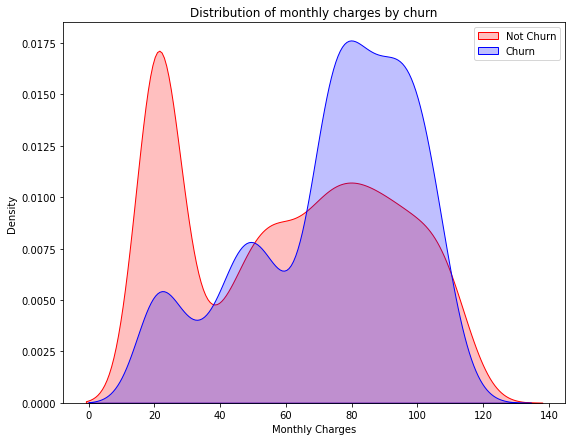

In [31]:
plt.figure(figsize = (9,7))
# Plot the distribution of monthly charges for customer who didn't churn
ax = sns.kdeplot(train.monthly_charges[~train.churn],
                color="Red", shade = True)
# On the same graph, plot the distribution for customers who did
ax = sns.kdeplot(train.monthly_charges[train.churn ],
                ax=ax, color="Blue", shade= True)

# Prettify the graph with some labels and a legend
ax.legend(["Not Churn","Churn"],loc='upper right')
ax.set_ylabel('Density')
ax.set_xlabel('Monthly Charges')
ax.set_title('Distribution of monthly charges by churn')

At first glance our hypothesis seems to be true.  The distribution higher monthly charges is more dense for customers who churn, and there is a large spike of low monthly charges for customers who don't churn.

We should perform a statistical test to be sure.

Adhering to the traditions of statistical anylsis we'll set the null hypothesis to assume that there's no significance and our alternate hypothesis as there is a significance.
And because we are dealing with two groups we'll use an independant t-test.

In [32]:
from scipy import stats

#Significance level 
alpha = 0.05

train_churn = train[train.churn]
train_not_churn = train[~train.churn]
# Mean of charges, the standard deviation, and the number of observations for each subset
mu_1 = train_not_churn.monthly_charges.mean()
sigma_1 = train_not_churn.monthly_charges.std()
nobs_1 = len(train_not_churn)
mu_2 = train_churn.monthly_charges.mean()
sigma_2 = train_churn.monthly_charges.std()
nobs_2 = len(train_churn)

In [33]:
t,p = stats.ttest_ind_from_stats(mu_1,sigma_1,nobs_1,mu_2,sigma_2,nobs_2, equal_var=False)
if p/2 < alpha:
    print ("We reject the null hypothesis and assume that there is a statistically significant difference.")

We reject the null hypothesis and assume that there is a statistically significant difference.


After performing the statistical test we can conclude that our original hypothesis is true, customers who pay more are more likely to churn.  So we are done right?

Well, not exactly.  Our hypothesis does answer a question, just not our company's question.  The company wants to know the best predictors for customer churn, and so far we've only identified one corellation.  We can't yet determine how good of a predictor monthly charges are.  To answer that we should look at the dataset as a whole.

To help us decide what to focus on we'll use pandas' `.corr()` method to quickly determine which columns are more likely than others.  This is one of those situations where having the dummy columns that I skipped earlier would be helpful, so I'll also create a new dataframe with those columns included.

In [34]:
full, _, __,___ = wrangle.train_test_validate_verify_split( wrangle.get_tidier_telco_data() )
full.corr().churn

is_male                                   0.012382
senior_citizen                            0.150619
partner                                  -0.160525
dependents                               -0.155533
tenure                                   -0.351130
phone_service                             0.015814
multiple_lines                            0.035606
online_security                          -0.191327
online_backup                            -0.081699
device_protection                        -0.077667
tech_support                             -0.156812
streaming_tv                              0.071561
streaming_movies                          0.072027
paperless_billing                         0.194968
monthly_charges                           0.192372
total_charges                            -0.196129
churn                                     1.000000
internet_service_type_dsl                -0.119117
internet_service_type_fiber optic         0.303823
internet_service_type_none     

That's a lot of numbers and isn't very easy to look at.  Let's visualize

Text(0.5, 1.0, 'Correllation with Churn')

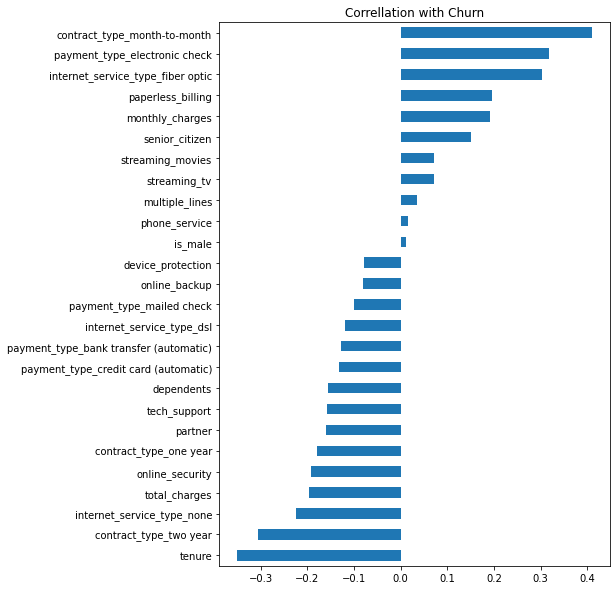

In [35]:
plt.figure(figsize=(7,10))
x = full.corr().churn.drop(labels='churn').sort_values()
ax = x.plot(kind='barh')
ax.set_title('Correllation with Churn')

That's still a lot of data.  Let's cut out the weaker correlations.

Text(0.5, 1.0, 'Correllation with Churn')

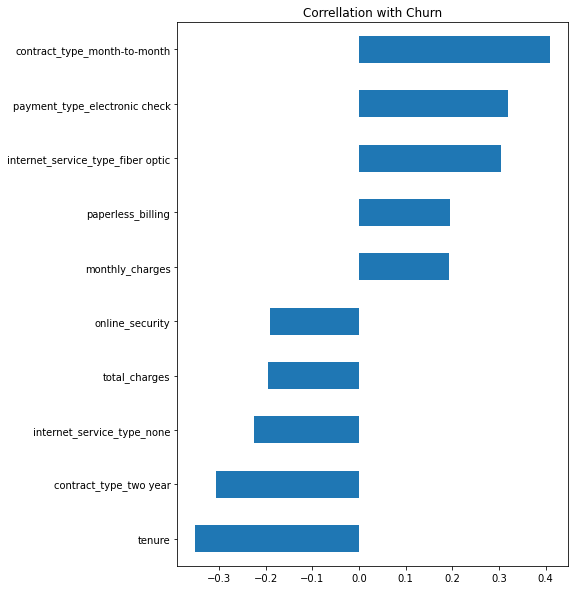

In [36]:
plt.figure(figsize=(7,10))
x = full.corr().churn.drop(labels='churn').sort_values()
ax = x[abs(x) > .18].plot(kind='barh')
ax.set_title('Correllation with Churn')

Unfortunately, none of these appear to be very strong corellations.  1.0 is a perfect correllation and the absolute value of all of these doesn't even get up to 0.5.  However, this process has helped us identify a good subset of fetures to start with.

In [37]:
potential_features = x[abs(x) > .18].index.tolist()
potential_features

['tenure',
 'contract_type_two year',
 'internet_service_type_none',
 'total_charges',
 'online_security',
 'monthly_charges',
 'paperless_billing',
 'internet_service_type_fiber optic',
 'payment_type_electronic check',
 'contract_type_month-to-month']

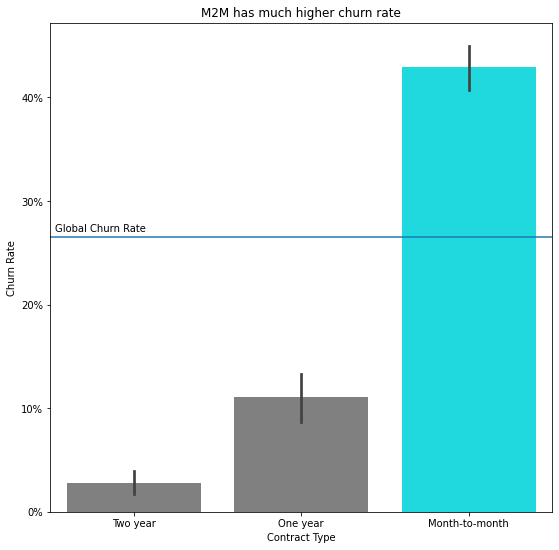

In [38]:
plt.figure(figsize = (9,9))
sblue = '#00F7FF'
gcr = train.churn.mean()
churn = sns.barplot(
                    data = train, 
                    y='churn', 
                    x='contract_type', 
                    order=['Two year','One year','Month-to-month'],
                    palette=['grey','grey',sblue],
                    ).set(
                        title='M2M has much higher churn rate',
                    )

plt.axhline(gcr)
plt.text(-0.47, gcr+.005, 'Global Churn Rate')
# plt.legend(title='Contract Type')
plt.ylabel('Churn Rate')
plt.xlabel('Contract Type')
plt.gca().yaxis.set_major_formatter('{:.0%}'.format)

In [39]:
train.internet_service_type.value_counts()

Fiber optic    1509
DSL            1230
None            782
Name: internet_service_type, dtype: int64

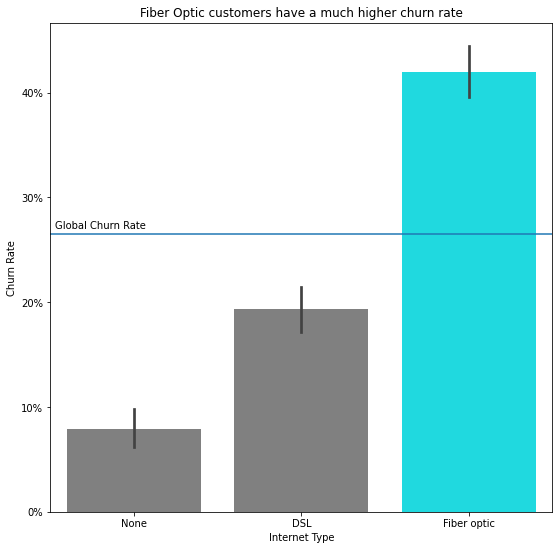

In [40]:
plt.figure(figsize = (9,9))
sblue = '#00F7FF'
gcr = train.churn.mean()
churn = sns.barplot(
                    data = train, 
                    y='churn', 
                    x='internet_service_type', 
                    order=['None','DSL','Fiber optic'],
                    palette=['grey','grey',sblue],
                    ).set(
                        title='Fiber Optic customers have a much higher churn rate',
                    )

plt.axhline(gcr)
plt.text(-0.47, gcr+.005, 'Global Churn Rate')
# plt.legend(title='Contract Type')
plt.ylabel('Churn Rate')
plt.xlabel('Internet Type')
plt.gca().yaxis.set_major_formatter('{:.0%}'.format)

In [41]:
inet_ctType = pd.crosstab(train.contract_type, train.internet_service_type)

In [42]:
def chi2_test(df, alpha=0.05):
    chi2, p, degf, expected = stats.chi2_contingency(df)
    print('Observed\n')
    print(df.values)
    print('---\nExpected\n')
    print(expected.astype(int))
    print('---\n')
    print(f'chi^2 = {chi2:.4f}')
    print(f'degf = {degf}')
    print(f'p     = {p:.4f}')
    print('---\n')
    if p < alpha:
        print("We reject the null hypothesis")
    else:
        print("We fail to reject the null hypothesis")

In [43]:
chi2_test(inet_ctType)
inet_ctType

Observed

[[ 630 1049  254]
 [ 278  258  188]
 [ 322  202  340]]
---
Expected

[[675 828 429]
 [252 310 160]
 [301 370 191]]
---

chi^2 = 341.3978
degf = 4
p     = 0.0000
---

We reject the null hypothesis


internet_service_type,DSL,Fiber optic,None
contract_type,,,
Month-to-month,630,1049,254
One year,278,258,188
Two year,322,202,340


In [44]:
train.payment_type.value_counts().index.tolist()[::-1]

['Credit card (automatic)',
 'Bank transfer (automatic)',
 'Mailed check',
 'Electronic check']

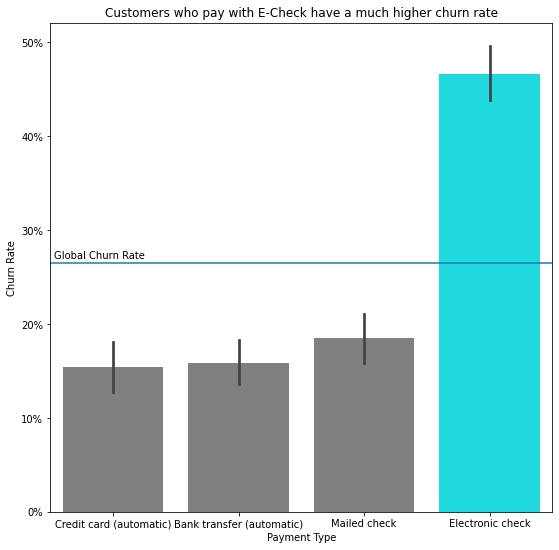

In [45]:
plt.figure(figsize = (9,9))
sblue = '#00F7FF'
gcr = train.churn.mean()
churn = sns.barplot(
                    data = train, 
                    y='churn', 
                    x='payment_type', 
                    order=train.payment_type.value_counts().index.tolist()[::-1],
                    palette=['grey','grey','grey',sblue],
                    ).set(
                        title='Customers who pay with E-Check have a much higher churn rate',
                    )

plt.axhline(gcr)
plt.text(-0.47, gcr+.005, 'Global Churn Rate')
# plt.legend(title='Contract Type')
plt.ylabel('Churn Rate')
plt.xlabel('Payment Type')
plt.gca().yaxis.set_major_formatter('{:.0%}'.format)

Text(0.5, 1.0, 'Distribution of Tenure by churn')

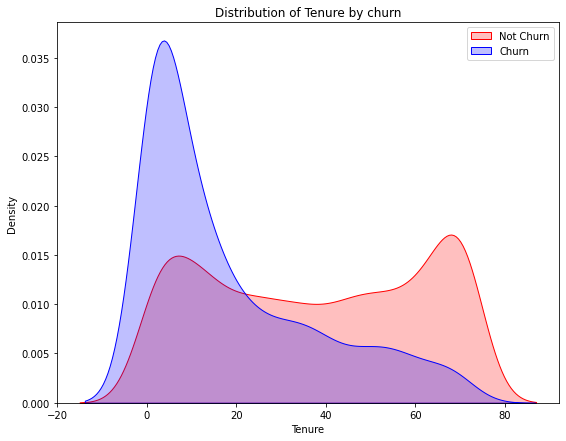

In [46]:
plt.figure(figsize = (9,7))
ax = sns.kdeplot(train.tenure[~train.churn],
                color="Red", shade = True)
ax = sns.kdeplot(train.tenure[train.churn ],
                ax=ax, color="Blue", shade= True)

# Prettify the graph with some labels and a legend
ax.legend(["Not Churn","Churn"],loc='upper right')
ax.set_ylabel('Density')
ax.set_xlabel('Tenure')
ax.set_title('Distribution of Tenure by churn')

# DS Pipeline Step 4: Modeling

Now that we have identified the most impactful drivers of churn, we can get to work feeding those features into some models and selecting one.

This is where we decide which metric we care about.  To do that it's helpful to think through the possible outcomes of our model and the costs associated with each.  First we need to define the outcomes:
 - True Positive: A customer who would churn is identified as likely to churn
 - True Negative: A customer who would not churn is identified as unlikely to churn
 - False Postive: A customer who would not churn is identified as likely to churn
 - False Negative: A customer who would churn is identified as unlikely to churn

Then we can think about the costs of each outcome.  We'll ignore the true predictions since there should be a benefit associated with those outcomes as opposed to a cost.
 - False Postive: Wasted effort from customer retention team (~1/2 hour of employee time = ~$12)
 - False Negative: Opportunity to retain customer is lost = potential revenue loss (Loss of customer ~$73/mo)

With the costs listed here we can find the point at which one metric outweighs another.

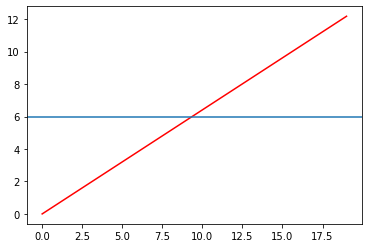

In [47]:
avg_cust_rev = train.monthly_charges.mean()
x = range(0,20)
y = [(x/100)*avg_cust_rev for x in x]
plt.plot(x,y, color='red')
plt.axhline(12/2)

If customer retention engagements result in at least %9.5 of customers who would have churned staying for an additional two months then the ROI breaks even.

This holds true regardless of the total number of false positives and any improvement in performance, either through longer retentions or higher retention rates, results in a positive return on investment.  Beacuse of this I think it is safe to say that we will want to optimize for recall (minimizing the false-negative rate)

In [48]:
train[train.churn].monthly_charges.mean()

73.74389721627408

In [49]:
train.churn.mean()

0.26526554955978415

In [50]:
#Redefine my datasets now that we're ready to model.
df = wrangle.get_tidier_telco_data()
train, test, validate, verify = wrangle.train_test_validate_verify_split(df)

In [51]:
X_train = train[potential_features]
y_train = train['churn']

In [52]:
potential_features

['tenure',
 'contract_type_two year',
 'internet_service_type_none',
 'total_charges',
 'online_security',
 'monthly_charges',
 'paperless_billing',
 'internet_service_type_fiber optic',
 'payment_type_electronic check',
 'contract_type_month-to-month']

In [53]:
def x_y_split(df):
    features = ['tenure',
                'contract_type_two year',
                'internet_service_type_none',
                # 'total_charges',
                'online_security',
                'monthly_charges',
                'paperless_billing',
                'internet_service_type_fiber optic',
                'payment_type_electronic check',
                'contract_type_month-to-month']
    x = df[features]
    y = df['churn']
    return x, y

In [54]:
X_train, y_train = x_y_split(train)

In [55]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [56]:
baseline_accuracy = 1- y_train.mean()

### Random Forest

In [57]:
def binary_classifier_stats(actual, predictions):
    tn, fp, fn, tp = metrics.confusion_matrix(actual,predictions).ravel()
    stats = {
            'accuracy' : metrics.accuracy_score(actual, predictions) ,
            'true_positive_rate' : tp/(tp+fp) ,
            'true_negative_rate' : tn/(tn+fn) ,
            'false_positive_rate' : fp/(tp+fp) ,
            'false_negative_rate' : fn/(tn+fn) ,
            'precision' : metrics.precision_score(actual, predictions),
            'recall'    : metrics.recall_score(actual, predictions),
            'f1-score'  : metrics.f1_score(actual, predictions)
            }
    return stats

In [58]:
rf = RandomForestClassifier(max_depth=8,
                            min_samples_leaf = 8,
                            random_state=8)

In [59]:
rf.fit(X_train, y_train)
pred = rf.predict(X_train)
binary_classifier_stats(y_train, pred)

{'accuracy': 0.8224936097699517,
 'true_positive_rate': 0.7024901703800787,
 'true_negative_rate': 0.8556925308194344,
 'false_positive_rate': 0.29750982961992134,
 'false_negative_rate': 0.14430746918056564,
 'precision': 0.7024901703800787,
 'recall': 0.5738758029978587,
 'f1-score': 0.6317030053034767}

c:\Users\Crux\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


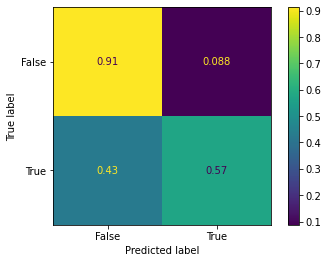

In [60]:
metrics.plot_confusion_matrix(rf, X_train, y_train, normalize='true')

#### Resampling

The accuracy on this model is misleading.  Remember that by just predicting false every time we get 73% accuracy.  This is why we are favoring recall as a metric, we want to minimize the amount of churning customer that aren't identified.

In researching how to overcome this problem I've come across a common issue in machine learning called "class imbalance".  In our data-sample, the number of not-churners outweigh the number of churners by a significan marigin.  To combat this there is a technique called "resampling" which involves duplicating samples of our target class so that they balance with the rest of the data.

Let's give it a try.

In [61]:
from sklearn.utils import resample


In [62]:
minority_upsample = resample( train[train.churn],   #DF of samples to replicate
                            replace = True,         #Implements resampling with replacement, Default=True
                            n_samples = len(train[~train.churn]), #Number of samples to produce
                            random_state= 8         #Random State seed for reproducibility
                            )

In [63]:
minority_upsample.shape, train[~train.churn].shape

((2587, 31), (2587, 31))

In [64]:
alter = pd.concat([minority_upsample, train[~train.churn]])
X_alter, y_alter = x_y_split(alter)

In [65]:
model = RandomForestClassifier(max_depth=8,
                            min_samples_leaf = 8,
                            random_state=8)

model.fit(X_alter, y_alter)
pred = model.predict(X_alter)
binary_classifier_stats(y_alter, pred)


{'accuracy': 0.817742558948589,
 'true_positive_rate': 0.7908704883227177,
 'true_negative_rate': 0.8500851788756388,
 'false_positive_rate': 0.2091295116772824,
 'false_negative_rate': 0.14991482112436116,
 'precision': 0.7908704883227177,
 'recall': 0.8639350599149594,
 'f1-score': 0.8257897653796417}

In [66]:
pred = model.predict(X_train)
binary_classifier_stats(y_train, pred)

{'accuracy': 0.7892644135188867,
 'true_positive_rate': 0.5698689956331878,
 'true_negative_rate': 0.9296693060083838,
 'false_positive_rate': 0.43013100436681223,
 'false_negative_rate': 0.0703306939916162,
 'precision': 0.5698689956331878,
 'recall': 0.8383297644539615,
 'f1-score': 0.6785095320623917}

In [67]:
X_test, y_test = x_y_split(test)
pred = model.predict(X_test)
binary_classifier_stats(y_test, pred)

{'accuracy': 0.7571022727272727,
 'true_positive_rate': 0.5294117647058824,
 'true_negative_rate': 0.9004629629629629,
 'false_positive_rate': 0.47058823529411764,
 'false_negative_rate': 0.09953703703703703,
 'precision': 0.5294117647058824,
 'recall': 0.7700534759358288,
 'f1-score': 0.627450980392157}

I am much happier with the performance of my model after the resampling process.  So much so that I'm going to go ahead and replace my training sets with the resampled data.

In [68]:
X_train, y_train = X_alter, y_alter

#### Random Forest Loops

In [69]:
out=[]
for i in range(2,20):
    rf = RandomForestClassifier(max_depth=i,
                                min_samples_leaf = 8,
                                random_state=8)
    rf.fit(X_train, y_train)
    pred = rf.predict(X_train)
    metric = binary_classifier_stats(y_train, pred)
    metric['depth'] = i
    metric['sample'] = 'train'
    out.append(metric)

    pred = rf.predict(X_test)
    metric = binary_classifier_stats(y_test, pred)
    metric['depth'] = i
    metric['sample'] = 'test'
    out.append(metric)

results = pd.DataFrame(out)


KeyboardInterrupt: 

<AxesSubplot:xlabel='depth', ylabel='precision'>

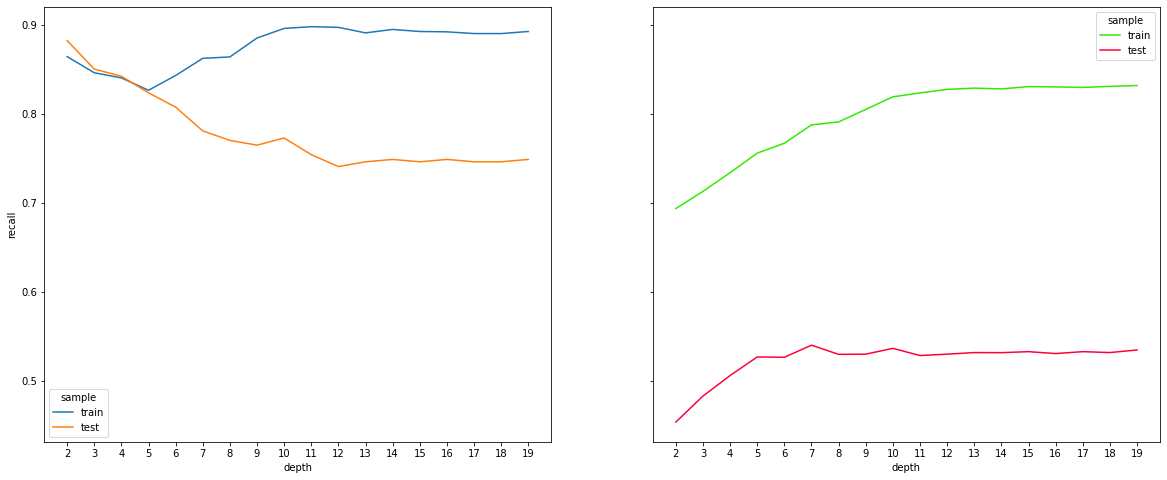

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, )
fig.set(figwidth=20,figheight=8)
plt.setp(ax, xticks=range(20))
sns.lineplot(data=results, x='depth', y='recall', hue='sample', ax=ax[0])
sns.lineplot(data=results, x='depth', y='precision', hue='sample', ax=ax[1], palette='prism')

I'll set my depth to 3 since that seems to have the best performance for both recall and accuracy.

#### Leaf loops

In [ ]:
out=[]
for i in range(20,300):
    rf = RandomForestClassifier(max_depth=3,
                                min_samples_leaf = i,
                                random_state=8)
    rf.fit(X_train, y_train)
    pred = rf.predict(X_train)
    metric = binary_classifier_stats(y_train, pred)
    metric['leaves'] = i
    metric['sample'] = 'train'
    out.append(metric)

    pred = rf.predict(X_test)
    metric = binary_classifier_stats(y_test, pred)
    metric['leaves'] = i
    metric['sample'] = 'test'
    out.append(metric)

results = pd.DataFrame(out)


<AxesSubplot:xlabel='leaves', ylabel='recall'>

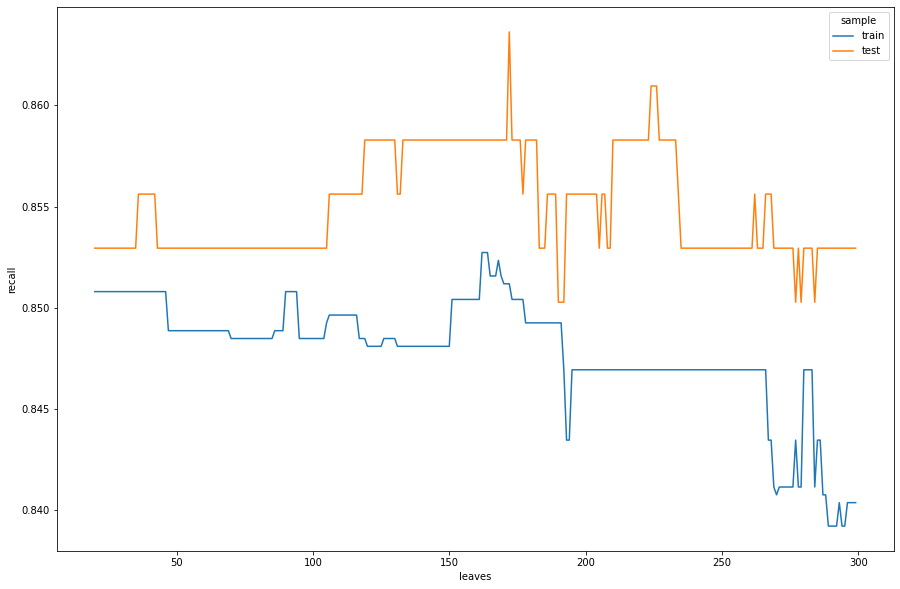

In [ ]:
plt.figure(figsize=(15,10))
sns.lineplot(data=results, x='leaves', y='recall', hue='sample')

Requiring a high number of samples in a leaf will help combat overfitting, but as we can see here the number to choose creates a lot of noise in the model's perfomance.  Considering that the max depth is set to 3, I don't beleive overfitting will be a problem we need to avoid in this instance.

In [ ]:
X_validate, y_validate = x_y_split(validate)
model = RandomForestClassifier(max_depth=3,
                            min_samples_leaf = 2,
                            random_state=8)

model.fit(X_train, y_train)
pred = model.predict(X_validate)
binary_classifier_stats(y_validate, pred)

{'accuracy': 0.7038789025543992,
 'true_positive_rate': 0.46833013435700577,
 'true_negative_rate': 0.9328358208955224,
 'false_positive_rate': 0.5316698656429942,
 'false_negative_rate': 0.06716417910447761,
 'precision': 0.46833013435700577,
 'recall': 0.8714285714285714,
 'f1-score': 0.6092384519350812}

### Logistic Regression

I'm happy with the model that I've created with the Random Forest classifier.  But to cover my bases I should also try a different algorithm.

Logistic Regression seems a good choice.

In [ ]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(random_state=8)
model.fit(X_train,y_train)
pred = model.predict(X_train)
binary_classifier_stats(y_train,pred)


{'accuracy': 0.758987243911867,
 'true_positive_rate': 0.7404881550610194,
 'true_negative_rate': 0.7805695142378559,
 'false_positive_rate': 0.2595118449389806,
 'false_negative_rate': 0.21943048576214405,
 'precision': 0.7404881550610194,
 'recall': 0.7974487823734054,
 'f1-score': 0.7679136422855015}

In [ ]:

out =[]

for i in range(1,101):
    c = i/100
    model = LogisticRegression(C=c, max_iter=200, random_state=8)
    model.fit(X_train,y_train)
    pred = model.predict(X_train)
    metric = binary_classifier_stats(y_train, pred)
    metric['i'] = i
    metric['sample'] ='train'
    out.append(metric)
    
    pred = model.predict(X_test)
    metric = binary_classifier_stats(y_test, pred)
    metric['i'] = i
    metric['sample'] ='test'
    out.append(metric)



<AxesSubplot:xlabel='i', ylabel='recall'>

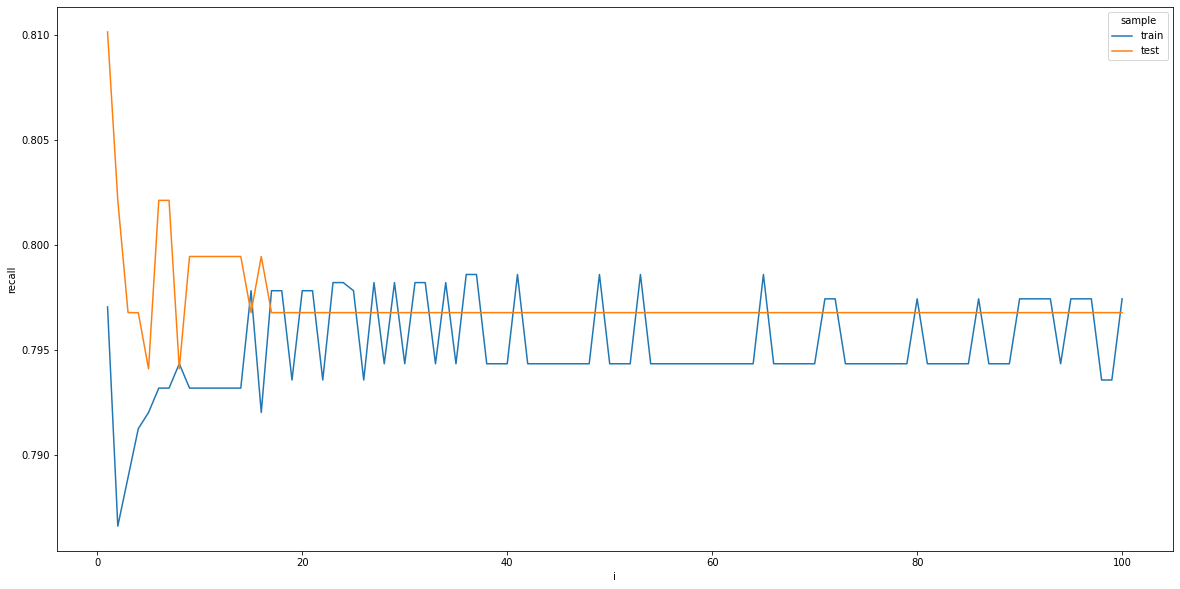

In [ ]:
df = pd.DataFrame(out)
plt.figure(figsize=(20,10))
sns.lineplot(data=df, x='i', y='recall', hue='sample')


<AxesSubplot:xlabel='i', ylabel='precision'>

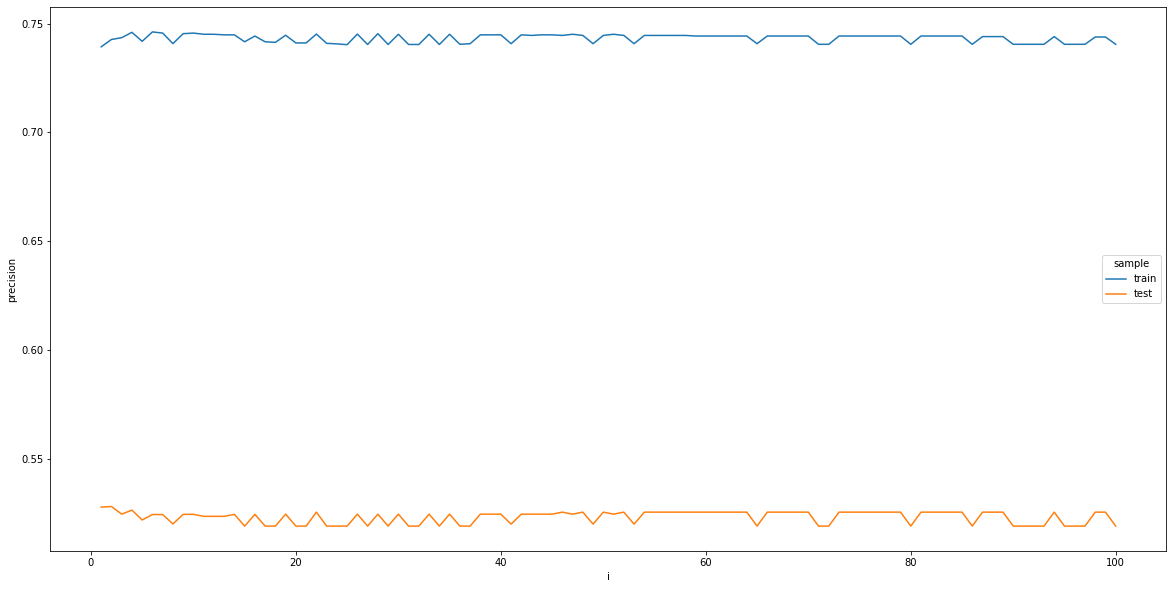

In [ ]:
df = pd.DataFrame(out)
plt.figure(figsize=(20,10))
sns.lineplot(data=df, x='i', y='precision', hue='sample')

## Final model selection

In [ ]:
model = LogisticRegression(max_iter=200, random_state=8)
model.fit(X_train,y_train)
pred = model.predict(X_test)
binary_classifier_stats(y_test, pred)

{'accuracy': 0.7485795454545454,
 'true_positive_rate': 0.5174825174825175,
 'true_negative_rate': 0.9066985645933014,
 'false_positive_rate': 0.4825174825174825,
 'false_negative_rate': 0.09330143540669857,
 'precision': 0.5174825174825175,
 'recall': 0.7914438502673797,
 'f1-score': 0.6257928118393236}

In [ ]:
model = LogisticRegression(max_iter=200, random_state=8)
model.fit(X_train,y_train)
pred = model.predict(X_validate)
binary_classifier_stats(y_validate, pred)

{'accuracy': 0.7294228949858089,
 'true_positive_rate': 0.4936440677966102,
 'true_negative_rate': 0.9196581196581196,
 'false_positive_rate': 0.5063559322033898,
 'false_negative_rate': 0.08034188034188035,
 'precision': 0.4936440677966102,
 'recall': 0.8321428571428572,
 'f1-score': 0.6196808510638298}

In [ ]:
np.unique(pred, return_counts=True)

(array([False,  True]), array([585, 472], dtype=int64))

In [ ]:
model = RandomForestClassifier(max_depth=8,
                            min_samples_leaf = 8,
                            random_state=8)
model.fit(X_train,y_train)
pred = model.predict(X_test)
binary_classifier_stats(y_test, pred)

{'accuracy': 0.7571022727272727,
 'true_positive_rate': 0.5294117647058824,
 'true_negative_rate': 0.9004629629629629,
 'false_positive_rate': 0.47058823529411764,
 'false_negative_rate': 0.09953703703703703,
 'precision': 0.5294117647058824,
 'recall': 0.7700534759358288,
 'f1-score': 0.627450980392157}

In [ ]:
model = RandomForestClassifier(max_depth=8,
                            min_samples_leaf = 8,
                            random_state=8)
model.fit(X_train,y_train)
pred = model.predict(X_validate)
binary_classifier_stats(y_validate, pred)

{'accuracy': 0.7313150425733207,
 'true_positive_rate': 0.49557522123893805,
 'true_negative_rate': 0.9074380165289256,
 'false_positive_rate': 0.504424778761062,
 'false_negative_rate': 0.09256198347107437,
 'precision': 0.49557522123893805,
 'recall': 0.8,
 'f1-score': 0.6120218579234972}

In [ ]:
np.unique(pred, return_counts=True)

(array([False,  True]), array([605, 452], dtype=int64))

Both of these models perform very well.  However, because the Logistic Regression model has better recall on average, I will select it as my best model and test it against the verify dataset.

In [ ]:
X_verify, y_verify = x_y_split(verify)
model = LogisticRegression(max_iter=200, random_state=8)
model.fit(X_train,y_train)
pred = model.predict(X_verify)
binary_classifier_stats(y_verify, pred)

{'accuracy': 0.7341532639545885,
 'true_positive_rate': 0.5,
 'true_negative_rate': 0.8985507246376812,
 'false_positive_rate': 0.5,
 'false_negative_rate': 0.10144927536231885,
 'precision': 0.5,
 'recall': 0.7758007117437722,
 'f1-score': 0.6080892608089261}

c:\Users\Crux\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


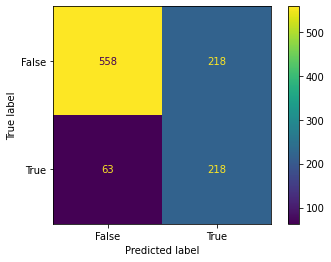

In [ ]:
metrics.plot_confusion_matrix(model, X_verify, y_verify,  )

In [ ]:
tn, fp, fn, tp = metrics.confusion_matrix(y_verify, pred).ravel()
tn,fp,fn,tp

(558, 218, 63, 218)

In [ ]:
import plotly.express as px
def confusion_matrix_treemap(tn,fp,fn,tp):
    fig = px.treemap(   title='Model Predictions compared to truth',
                        values= [0,0]+[tn,fp,fn,tp] ,
                        names= ['positive','negative','true_negative','false_positive','false_negative','true_positive'],
                        parents=['','', 'negative','negative','positive','positive'],
                        width=600, height=400,
                        color=['positive','negative','true_negative','false_positive','false_negative','true_positive'],
                        color_discrete_map= {'positive':'FF221F',
                                            'negative':'099C4E',
                                            'true_negative':'099C4E',
                                            'false_positive':'FF221F',
                                            'false_negative':'099C4E',
                                            'true_positive':'FF221F'}
                        )

    fig.update_traces(root_color="lightgrey")
    fig.update_layout(margin = dict(t=45, l=0, r=0, b=0))
    fig.show()

confusion_matrix_treemap(tn,fp,fn,tp)

It seems to perform consistently with the recall score hovering around 80% in both in-sample and out-of-sample datasets.  Onto the next step!

# DS Pipline step 5: Delivery

Now we reach the stage in the pipeline where we need to think about how to share these findings and this model with others.

Remember that there are two deliverables, the first being a report answering the company's questions, and the second being a machine-learning model that will be used to monitor the customer data.  

To facilitate the first deliverable we will create a new Jupyter Notebook called [Final_Report.ipynb](./Final_report.ipynb).

And to facilitate the second, we will create a python script that can quickly build our optimized model. [model.py](./model.py)

### Additional helpers

**model**: To hide away the code necessary for training the model I wrapped it in a function that returns a fitted model.

In [ ]:
# Import the ready to model data
df = wrangle.get_tidier_telco_data()

# Split off the training data
train, test, validate, verify = wrangle.train_test_validate_verify_split(df)

# Upsample the training data to balance a class imbalance
minority_upsample = resample( train[train.churn],   #DF of samples to replicate
                            replace = True,         #Implements resampling with replacement, Default=True
                            n_samples = len(train[~train.churn]), #Number of samples to produce
                            random_state= 8         #Random State seed for reproducibility
                            )
#Then glue the upsample to the original
train = pd.concat([minority_upsample, train[~train.churn]])

# Separate the features from the target
X_train, y_train = wrangle.x_y_split(train)

# Create the algorithm class
model = LogisticRegression(max_iter=200, random_state=8)

# and fit it to our training data
model.fit(X_train,y_train) 

model.predict_proba(X_train)

array([[0.57269702, 0.42730298],
       [0.46306414, 0.53693586],
       [0.85745989, 0.14254011],
       ...,
       [0.84240123, 0.15759877],
       [0.97701533, 0.02298467],
       [0.72248867, 0.27751133]])

In [ ]:
def get_model():
    # Import the ready to model data
    df = wrangle.get_tidier_telco_data()

    # Split off the training data
    train, test, validate, verify = wrangle.train_test_validate_verify_split(df)

    # Upsample the training data to balance a class imbalance
    minority_upsample = resample( train[train.churn],   #DF of samples to replicate
                                replace = True,         #Implements resampling with replacement, Default=True
                                n_samples = len(train[~train.churn]), #Number of samples to produce
                                random_state= 8         #Random State seed for reproducibility
                                )
    #Then glue the upsample to the original
    train = pd.concat([minority_upsample, train[~train.churn]])

    # Separate the features from the target
    X_train, y_train = wrangle.x_y_split(train)

    # Create the algorithm class
    model = LogisticRegression(max_iter=200, random_state=8)

    # and fit it to our training data
    model.fit(X_train,y_train) 
    
    return model

model = get_model()
model.predict_proba(X_validate)

array([[0.72538672, 0.27461328],
       [0.92412146, 0.07587854],
       [0.41077447, 0.58922553],
       ...,
       [0.3383912 , 0.6616088 ],
       [0.57025497, 0.42974503],
       [0.96393211, 0.03606789]])

**wrangle**: I wanted a way to loop through each dataset quickly in the final report so I've created this function that returns a dictionary of dataframes

In [ ]:
def get_xy_sets():
    # Import the ready to model data
    df = wrangle.get_tidier_telco_data()

    # Split into the four sample-groups
    train, test, validate, verify = wrangle.train_test_validate_verify_split(df)

    # Get the X and Y sets for each dataset
    X_train, y_train = wrangle.x_y_split(train)
    X_test, y_test = wrangle.x_y_split(test)
    X_validate, y_validate = wrangle.x_y_split(validate)
    X_verify, y_verify = wrangle.x_y_split(verify)

    # Package everything into a neat dictionary and return
    d= {
        'train': {'x':X_train, 'y':y_train, 'o':train},
        'test': {'x':X_test, 'y':y_test, 'o':test},
        'validate': {'x':X_validate, 'y':y_validate, 'o':validate},
        'verify': {'x':X_verify, 'y':y_verify, 'o':verify}
    }
    return d

sets = get_xy_sets()
sets['train']['x'].head()

,tenure,contract_type_two year,internet_service_type_none,online_security,monthly_charges,paperless_billing,internet_service_type_fiber optic,payment_type_electronic check,contract_type_month-to-month
462,72,True,False,True,116.40,True,True,False,False
6544,13,False,False,False,96.85,True,True,True,True
1446,1,False,False,False,45.65,True,False,True,True
3662,2,False,False,False,64.20,True,False,False,True
1559,14,False,False,False,74.30,True,True,True,True


### Predictions csv

This is less directly a deliverable to the company, and is instead a deliverable to the class project.

In [ ]:
# Get a freshly trained model
model = get_model()
# Load the datasets
sets = get_xy_sets()

# Set up the columns in the resulting csv and paste them together
frames = [
            sets['verify']['o'].reset_index().customer_id,
            pd.DataFrame(model.predict(sets['verify']['x']))[0],
            pd.DataFrame(model.predict_proba(sets['verify']['x']))[1] ,
            ]
out = pd.concat(frames, axis=1)

# Label the columns and write to file
out.columns = ['customer_id','churn_pred','churn_proba']
out.to_csv('./predictions.csv',index=False)